In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from print_color import print
import locale 
from datetime import datetime
locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')


'fr_FR.UTF-8'

In [2]:
BOAB = pd.read_csv("../data/BRVM-Public-Services.csv",index_col="Date")

In [3]:
debut = -365
fin = len(BOAB)
boab = BOAB.iloc[debut:]

In [4]:
# creation de de colonne de moyenne mobile

# moyenne mobile rapide / court terme
boab["MA10"] = boab["Close"].rolling(6).mean() #10

# moyenne mobile lente / long terme
boab["MA50"] = boab["Close"].rolling(10).mean() #40

boab = boab.dropna() ;

C:\Users\steph\AppData\Local\Temp\ipykernel_5544\1553252490.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boab["MA10"] = boab["Close"].rolling(6).mean() #10
C:\Users\steph\AppData\Local\Temp\ipykernel_5544\1553252490.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boab["MA50"] = boab["Close"].rolling(10).mean() #40


In [5]:
# creation de la liste position
condition = [boab["MA10"]>boab["MA50"] , boab["MA10"]<boab["MA50"]]
# creation d'une liste choix de deux element
choix = [1,0]
# 
boab['P'] = np.select(condition, choix)

In [6]:
boab

,Dernier,Ouv.,Plus Haut,Plus Bas,Vol.,Variation %,Close,High,Low,Open,MA10,MA50,P
Date,,,,,,,,,,,,,


In [7]:
condition = []
signal_achat = []
signal_vente = []
date_1 = boab.index[0]
stock = 0 # permet d'eviter d'acheter quand on pas de stock au debut

for date in boab.index :
    if boab["MA10"].loc[date] > boab["MA50"].loc[date] :
        condition.append(1)
    else :
        condition.append(0)
    
    if( boab["MA10"].loc[date] > boab["MA50"].loc[date] ) and (boab["MA10"].loc[date_1] < boab["MA50"].loc[date_1]) and stock == 0:
        signal_achat.append(boab["Close"].loc[date])
        stock = 1

    else :
        signal_achat.append(np.nan)

    
    if( boab["MA10"].loc[date] < boab["MA50"].loc[date] ) and (boab["MA10"].loc[date_1] > boab["MA50"].loc[date_1]) and (stock == 1):
        signal_vente.append(boab["Close"].loc[date])
        stock = 0
    else :
        signal_vente.append(np.nan)
        
    date_1 = date

boab["Position"] = condition
        


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
for i in range(len(boab)-1 , 0 , -1 ) :
    if signal_achat[i] > 0 :
        signal_achat[i] = np.nan
        break
        

In [ ]:
achat_vente = []
stock = 0
for i in range( len(boab) ) :
    if signal_achat[i] > 0 and stock != 1:
        achat_vente.append('acheter')
        stock = 1
    elif signal_vente[i] > 0 and stock != 0 :
        achat_vente.append('vendre' )
        stock=0
    else :
        achat_vente.append(np.nan)

boab['achat_vente'] = achat_vente

C:\Users\steph\AppData\Local\Temp\ipykernel_11804\4028229523.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boab['achat_vente'] = achat_vente


Text(0, 0.5, 'Prix de cloture des actions BOAB')

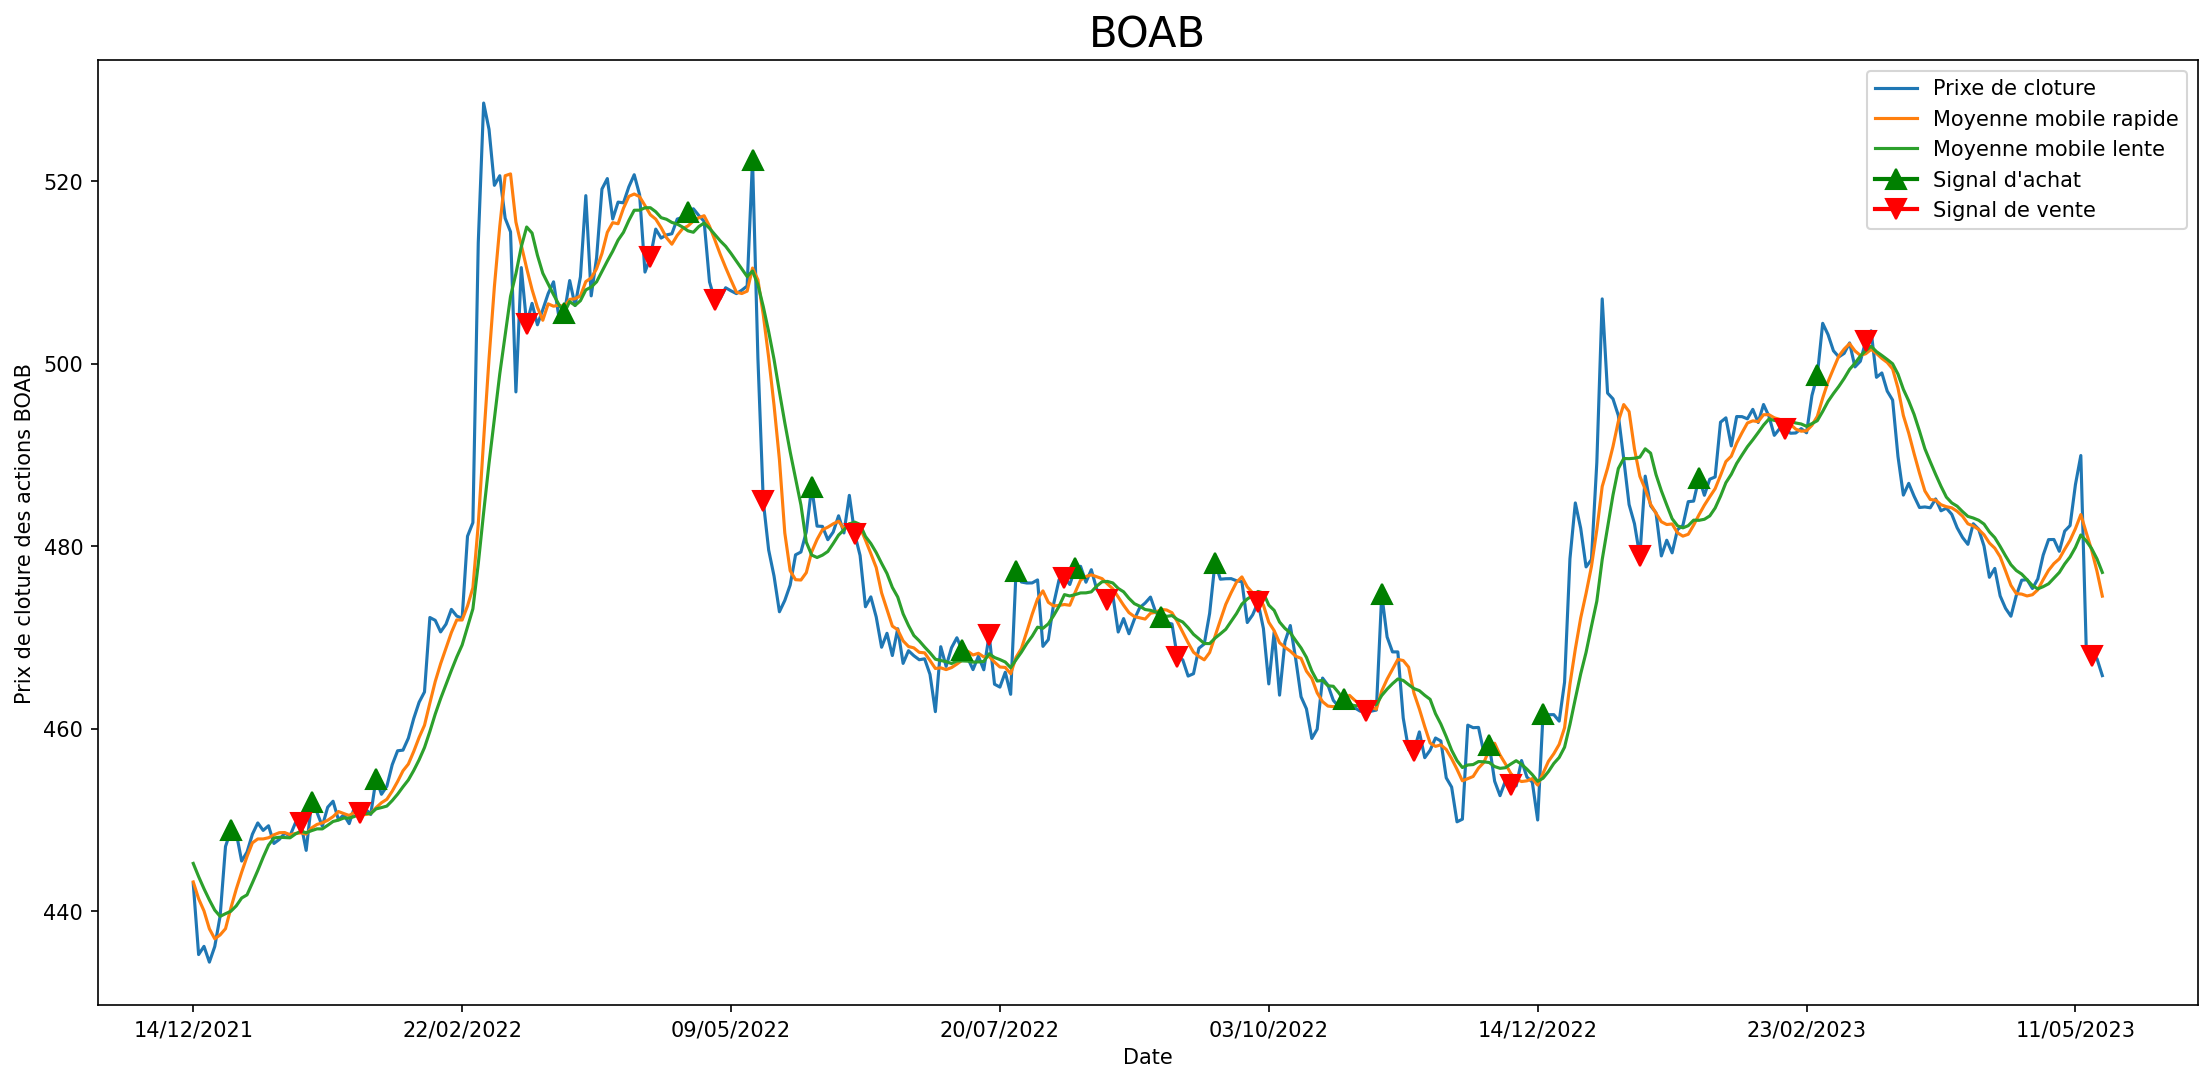

In [ ]:
fig = plt.figure(figsize=(14,7), dpi=150)

axe1 = fig.add_axes([0,1,1,0.9])

axe1 = boab["Close"].plot(label='Prixe de cloture') 
axe1 = boab["MA10"].plot(label='Moyenne mobile rapide')
axe1 = boab["MA50"].plot(label='Moyenne mobile lente')

axe1.plot(boab.index , signal_achat , marker='^',color='green',markersize=10,label = "Signal d'achat",linewidth=2)
axe1.plot(boab.index , signal_vente , marker='v',color='red',markersize=10,label = "Signal de vente",linewidth=2)

axe1.legend()
axe1.set_title("BOAB" , fontsize=20) 
axe1.set_ylabel("Prix de cloture des actions BOAB")


## Backtesting

In [ ]:
benefice = 0
depart = 1000
d = depart
nombre = 0
total = 0

for i in range( len( boab ) ) :
    if boab['achat_vente'].iloc[i] == 'acheter' :

        nombre = depart/boab['Close'].iloc[i]
        entrer = nombre*boab['Close'].iloc[i]

    elif boab['achat_vente'].iloc[i] == 'vendre' :

        sorti = (nombre*boab['Close'].iloc[i])
        benefice += sorti-entrer
        
        total += sorti
        depart = sorti
    else :
        pass

pourcentage_befice = 100*(benefice/d)

In [ ]:
date_depart = datetime.strptime( BOAB.iloc[debut].name , "%d/%m/%Y" ).strftime("%A %d %B, %Y ")
date_fin = datetime.strptime( BOAB.iloc[fin-1].name , "%d/%m/%Y" ).strftime("%A %d %B, %Y ")

print("Avec un capitale de depart de " ,end="")
print("{:,.2f} Fcfa".format(d) , color='green')
print("nous avons réalisé un benefice de ",end='')
print("{:.2f} %".format(pourcentage_befice) , color='green')
print("Soit un benefice total de ",end='')
print("{:,.2f} Fcfa".format(benefice) , color='green')
print("Sur la periode allant du ",end='')
print(date_depart , color="blue" , end="") ; print(" au " ,end="")
print(date_fin , color="blue" , end="")


Avec un capitale de depart de 1,000.00 Fcfa
nous avons réalisé un benefice de -0.63 %
Soit un benefice total de -6.35 Fcfa
Sur la periode allant du mercredi 01 décembre, 2021  au vendredi 19 mai, 2023 